**Project on Detection and Repair of Multi-Label Classification via Influence Signals**

**Sedat ARSLAN**

This code include CleanLab and Holistic Label Correction Algorithms with a dataset that will be noised.

**All imports here :**

In [5]:
!pip install CleanLab
!pip install Cleanlab[datalab]

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import tensorflow_datasets as tfds
from tensorflow.keras import optimizers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import sklearn.base
from cleanlab.filter import find_label_issues
from cleanlab import Datalab
from cleanlab.internal.multilabel_utils import int2onehot, onehot2int
!pip install cleanlab scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import average_precision_score
from cleanlab.multilabel_classification.filter import find_label_issues
from cleanlab.multilabel_classification.filter import find_multilabel_issues_per_class
from cleanlab.benchmarking.noise_generation import generate_noise_matrix_from_trace
from cleanlab.benchmarking.noise_generation import generate_noisy_labels
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models as torch_models
import torchvision.transforms as T
from sklearn.metrics import hamming_loss

#Initial Data

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 126s 10s/step - accuracy: 0.0521 - loss: 0.4847 - val_accuracy: 0.1900 - val_loss: 0.2825
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - accuracy: 0.1020 - loss: 0.2709 - val_accuracy: 0.1900 - val_loss: 0.2711
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 126s 10s/step - accuracy: 0.1237 - loss: 0.2554 - val_accuracy: 0.1900 - val_loss: 0.2606
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 146s 10s/step - accuracy: 0.0980 - loss: 0.2503 - val_accuracy: 0.1900 - val_loss: 0.2638
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 127s 10s/step - accuracy: 0.1205 - loss: 0.2355 - val_accuracy: 0.1700 - val_loss: 0.2572
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.1699 - loss: 0.2168 - val_accuracy: 0.1900 - val_loss: 0.2540
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.2088 - loss: 0.2056 - val_accuracy: 0.1800 - val_loss: 0.2585
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.3035 - loss: 0.1867 - val_accuracy: 0.

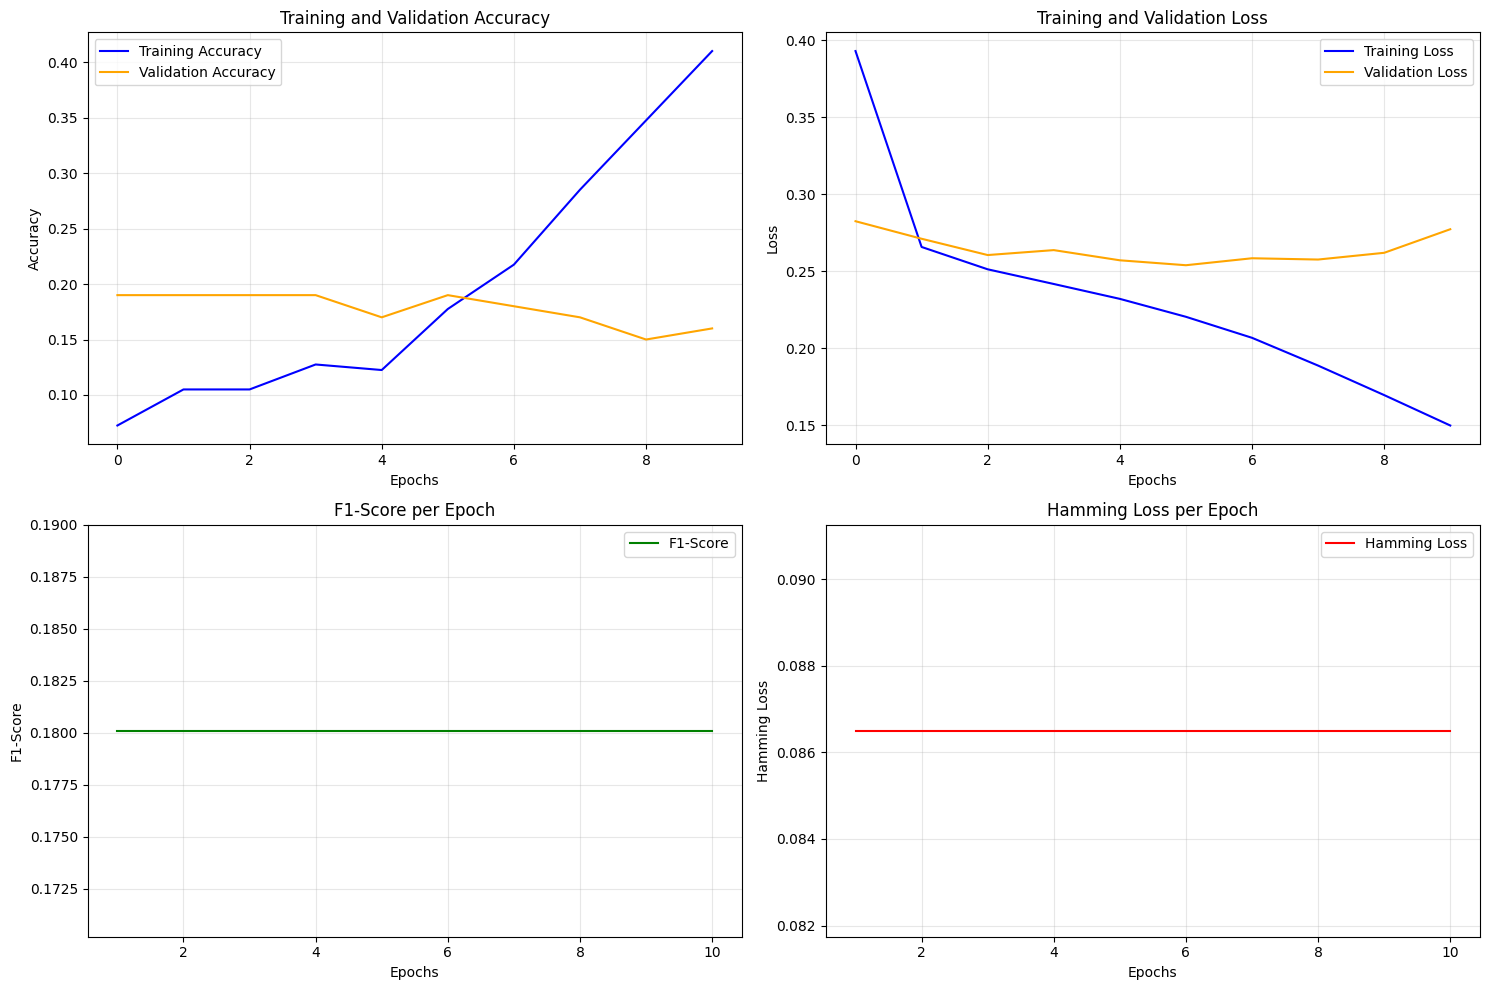

In [19]:
data, info = tfds.load("voc/2007", split="train[:20%]", with_info=True)

label_names = info.features["objects"]["label"].names
num_labels = len(label_names)

binary_labels = []
images = []

for sample in data:
    labels = np.zeros(num_labels, dtype=int)
    for label_id in sample["objects"]["label"].numpy():
        labels[label_id] = 1
    binary_labels.append(labels)
    image = Image.fromarray(sample["image"].numpy())
    image = image.resize((224, 224))
    images.append(np.array(image))

binary_labels = np.array(binary_labels)
images = np.array(images)

images = images.astype('float32')
images = images / 255.0

X_train, X_test, y_train, y_test = train_test_split(images, binary_labels, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary, average='micro')
    hamming = hamming_loss(y_true, y_pred_binary)
    return f1, hamming

f1_scores = []
hamming_losses = []

for epoch in range(10):
    y_pred = model.predict(X_test, verbose=0)
    f1, hamming = calculate_metrics(y_test, y_pred)
    f1_scores.append(f1)
    hamming_losses.append(hamming)

def plot_metrics(history, f1_scores, hamming_losses):
    plt.figure(figsize=(15, 10))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(range(1, 11), f1_scores, label='F1-Score', color='green')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Hamming Loss
    plt.subplot(2, 2, 4)
    plt.plot(range(1, 11), hamming_losses, label='Hamming Loss', color='red')
    plt.title('Hamming Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Hamming Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_metrics(history, f1_scores, hamming_losses)


#NOISED DATASET

Selected noisy column indices: [10  0  9 13]
Introduced noise in 80 samples and 4 columns.
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 10s/step - accuracy: 0.0253 - loss: 0.4871 - val_accuracy: 0.1900 - val_loss: 0.3189
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 10s/step - accuracy: 0.0710 - loss: 0.3373 - val_accuracy: 0.1900 - val_loss: 0.2875
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.0821 - loss: 0.3200 - val_accuracy: 0.1200 - val_loss: 0.2930
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 10s/step - accuracy: 0.0932 - loss: 0.3150 - val_accuracy: 0.1900 - val_loss: 0.2872
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.1592 - loss: 0.2990 - val_accuracy: 0.1900 - val_loss: 0.2773
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 129s 10s/step - accuracy: 0.2329 - loss: 0.2807 - val_accuracy: 0.1600 - val_loss: 0.2834
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 129s 10s/step - accuracy: 0.1952 - loss: 0.2671 - val_accuracy: 0.1400 - val_loss: 0.3068
Epoch 8/10
13

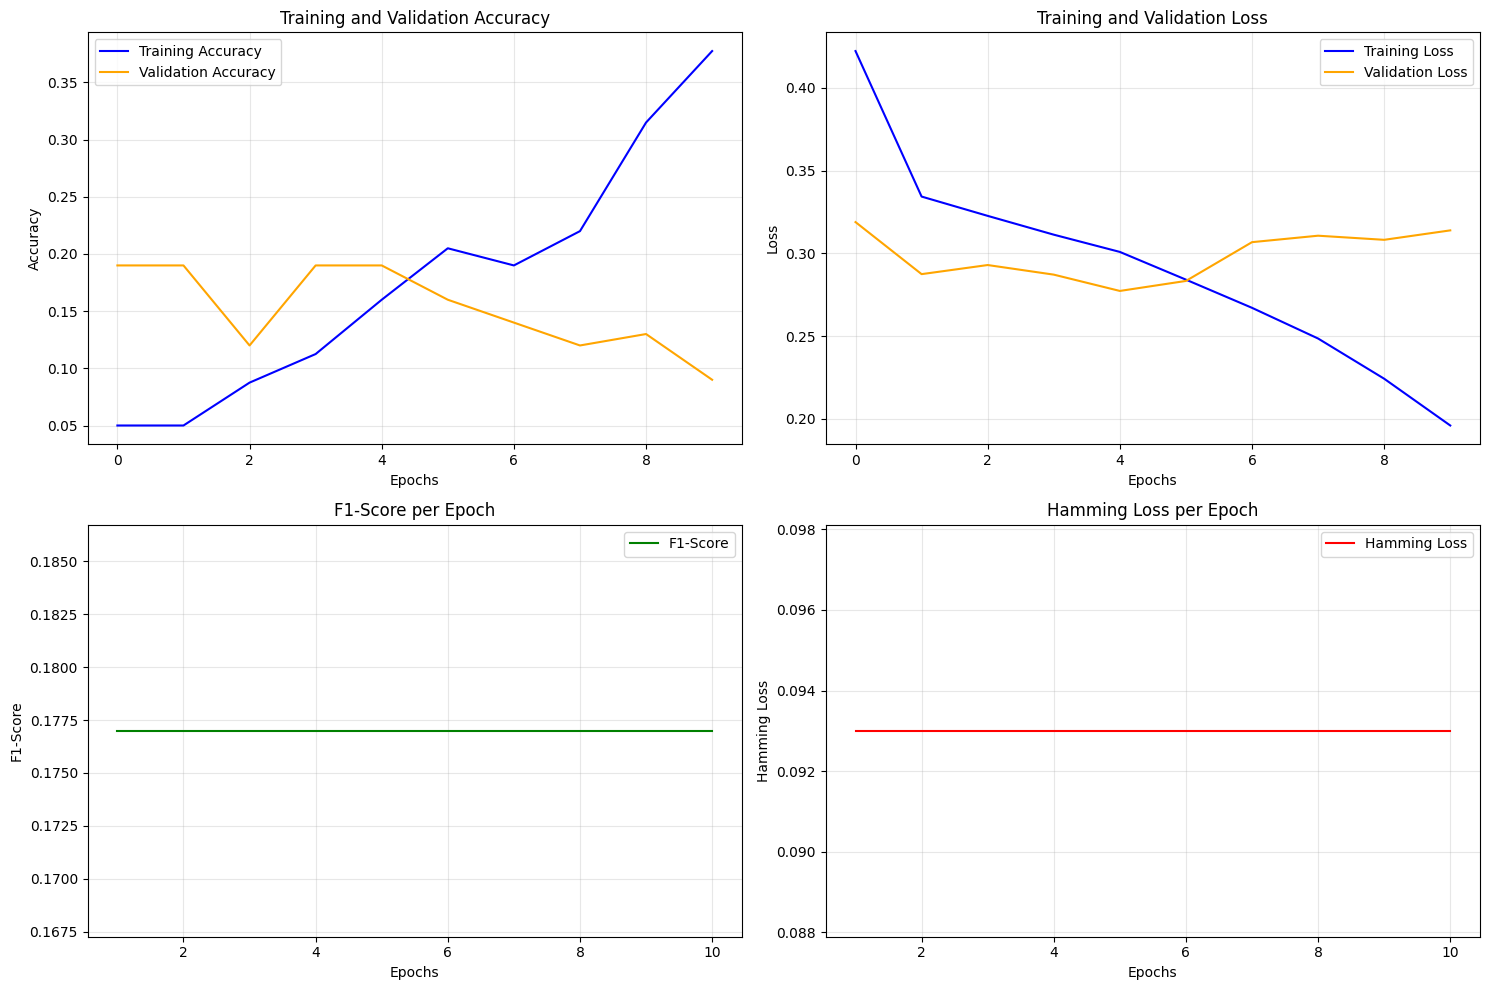

In [21]:
data, info = tfds.load("voc/2007", split="train[:20%]", with_info=True)

label_names = info.features["objects"]["label"].names
num_labels = len(label_names)

binary_labels = []
images = []

for sample in data:
    labels = np.zeros(num_labels, dtype=int)
    for label_id in sample["objects"]["label"].numpy():
        labels[label_id] = 1
    binary_labels.append(labels)
    image = Image.fromarray(sample["image"].numpy())
    image = image.resize((224, 224))
    images.append(np.array(image))

binary_labels = np.array(binary_labels)
images = np.array(images)
images = images.astype('float32')
images = images / 255.0

X_train, X_test, y_train, y_test = train_test_split(images, binary_labels, test_size=0.2, random_state=42)

#bruit dans les labels
noise_rate_samples = 0.2  # 20% des échantillons
noise_rate_columns = 0.2  # 20% des colonnes à contaminer

num_samples = len(y_train)
num_noisy_samples = int(num_samples * noise_rate_samples)
num_columns = y_train.shape[1]
num_noisy_columns = int(num_columns * noise_rate_columns)

np.random.seed(42)

noisy_sample_indices = np.random.choice(num_samples, num_noisy_samples, replace=False)
noisy_column_indices = np.random.choice(num_columns, num_noisy_columns, replace=False)
print(f"Selected noisy column indices: {noisy_column_indices}")

y_noisy = y_train.copy()

for idx in noisy_sample_indices:
    for col in noisy_column_indices:
        y_noisy[idx, col] = 1 - y_noisy[idx, col]

print(f"Introduced noise in {num_noisy_samples} samples and {num_noisy_columns} columns.")

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_noisy, epochs=10, batch_size=32, validation_data=(X_test, y_test))

def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary, average='micro')
    hamming = hamming_loss(y_true, y_pred_binary)
    return f1, hamming

f1_scores = []
hamming_losses = []

for epoch in range(10):
    y_pred = model.predict(X_test, verbose=0)
    f1, hamming = calculate_metrics(y_test, y_pred)
    f1_scores.append(f1)
    hamming_losses.append(hamming)

def plot_metrics(history, f1_scores, hamming_losses):
    plt.figure(figsize=(15, 10))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(range(1, 11), f1_scores, label='F1-Score', color='green')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Hamming Loss
    plt.subplot(2, 2, 4)
    plt.plot(range(1, 11), hamming_losses, label='Hamming Loss', color='red')
    plt.title('Hamming Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Hamming Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_metrics(history, f1_scores, hamming_losses)

#AFTER CLEANLAB

In [29]:
data, info = tfds.load("voc/2007", split="train[:20%]", with_info=True)

label_names = info.features["objects"]["label"].names
num_labels = len(label_names)

binary_labels = []
images = []

for sample in data:
    labels = np.zeros(num_labels, dtype=int)
    for label_id in sample["objects"]["label"].numpy():
        labels[label_id] = 1
    binary_labels.append(labels)
    image = Image.fromarray(sample["image"].numpy())
    image = image.resize((224, 224))
    images.append(np.array(image))

binary_labels = np.array(binary_labels)
images = np.array(images)
images = images.astype('float32')
images = images / 255.0

X_train, X_test, y_train, y_test = train_test_split(images, binary_labels, test_size=0.2, random_state=42)

#bruit dans les labels
noise_rate_samples = 0.2  # 20% des échantillons
noise_rate_columns = 0.2  # 20% des colonnes à contaminer

num_samples = len(y_train)
num_noisy_samples = int(num_samples * noise_rate_samples)
num_columns = y_train.shape[1]
num_noisy_columns = int(num_columns * noise_rate_columns)

np.random.seed(42)

noisy_sample_indices = np.random.choice(num_samples, num_noisy_samples, replace=False)
noisy_column_indices = np.random.choice(num_columns, num_noisy_columns, replace=False)

y_noisy = y_train.copy()

for idx in noisy_sample_indices:
    for col in noisy_column_indices:
        y_noisy[idx, col] = 1 - y_noisy[idx, col]  #0 -> 1 ou 1 -> 0

labels_list = []
for row in y_noisy:
    lbls = np.where(row == 1)[0].tolist()
    if len(lbls) == 0:
        lbls = [np.random.randint(num_labels)]
    labels_list.append(lbls)

X_train_flat = X_train.reshape(len(X_train), -1)
single_class_labels = [random.choice(i) for i in labels_list]

clf = OneVsRestClassifier(RandomForestClassifier(random_state=0))
pred_probs = np.zeros(shape=(len(labels_list), num_labels))
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train_index, test_index in kf.split(X=X_train_flat, y=single_class_labels):
    clf_cv = sklearn.base.clone(clf)
    X_train_cv, X_test_cv = X_train_flat[train_index], X_train_flat[test_index]
    y_train_cv, y_test_cv = y_noisy[train_index], y_noisy[test_index]
    clf_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = clf_cv.predict_proba(X_test_cv)
    pred_probs[test_index] = y_pred_cv


lab = Datalab(data={"labels": labels_list}, label_name="labels", task="multilabel")
lab.find_issues(pred_probs=pred_probs, issue_types={"label": {}})
label_issues = lab.get_issues("label")
issues = label_issues.query("is_label_issue").index.values

detected_set = set(issues)
noisy_set = set(noisy_sample_indices)

tp = len(detected_set.intersection(noisy_set))
fp = len(detected_set - noisy_set)
fn = len(noisy_set - detected_set)
tn = len(set(range(num_samples)) - (noisy_set.union(detected_set)))

precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
recall = tp / (tp+fn) if (tp+fn)>0 else 0.0
f1 = (2*precision*recall)/(precision+recall) if (precision+recall)>0 else 0.0

print("Cleanlab Detection Performance:")
print(f" Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

mask = np.ones(num_samples, dtype=bool)
mask[issues] = False
X_corrected = X_train[mask]
y_corrected = y_noisy[mask]

model_corrected = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='sigmoid')
])

model_corrected.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

history_corrected = model_corrected.fit(X_corrected, y_corrected, epochs=10, batch_size=32, validation_data=(X_test, y_test))

def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary, average='micro')
    hamming = hamming_loss(y_true, y_pred_binary)
    return f1, hamming

f1_scores = []
hamming_losses = []

for epoch in range(10):
    y_pred = model_corrected.predict(X_test, verbose=0)
    f1, hamming = calculate_metrics(y_test, y_pred)
    f1_scores.append(f1)
    hamming_losses.append(hamming)

def plot_metrics(history, f1_scores, hamming_losses):
    plt.figure(figsize=(15, 10))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(range(1, 11), f1_scores, label='F1-Score', color='green')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Hamming Loss
    plt.subplot(2, 2, 4)
    plt.plot(range(1, 11), hamming_losses, label='Hamming Loss', color='red')
    plt.title('Hamming Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Hamming Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_metrics(history_corrected, f1_scores, hamming_losses)

Selected noisy column indices: [10  0  9 13]
Introduced noise in 80 samples and 4 columns.


KeyboardInterrupt: 

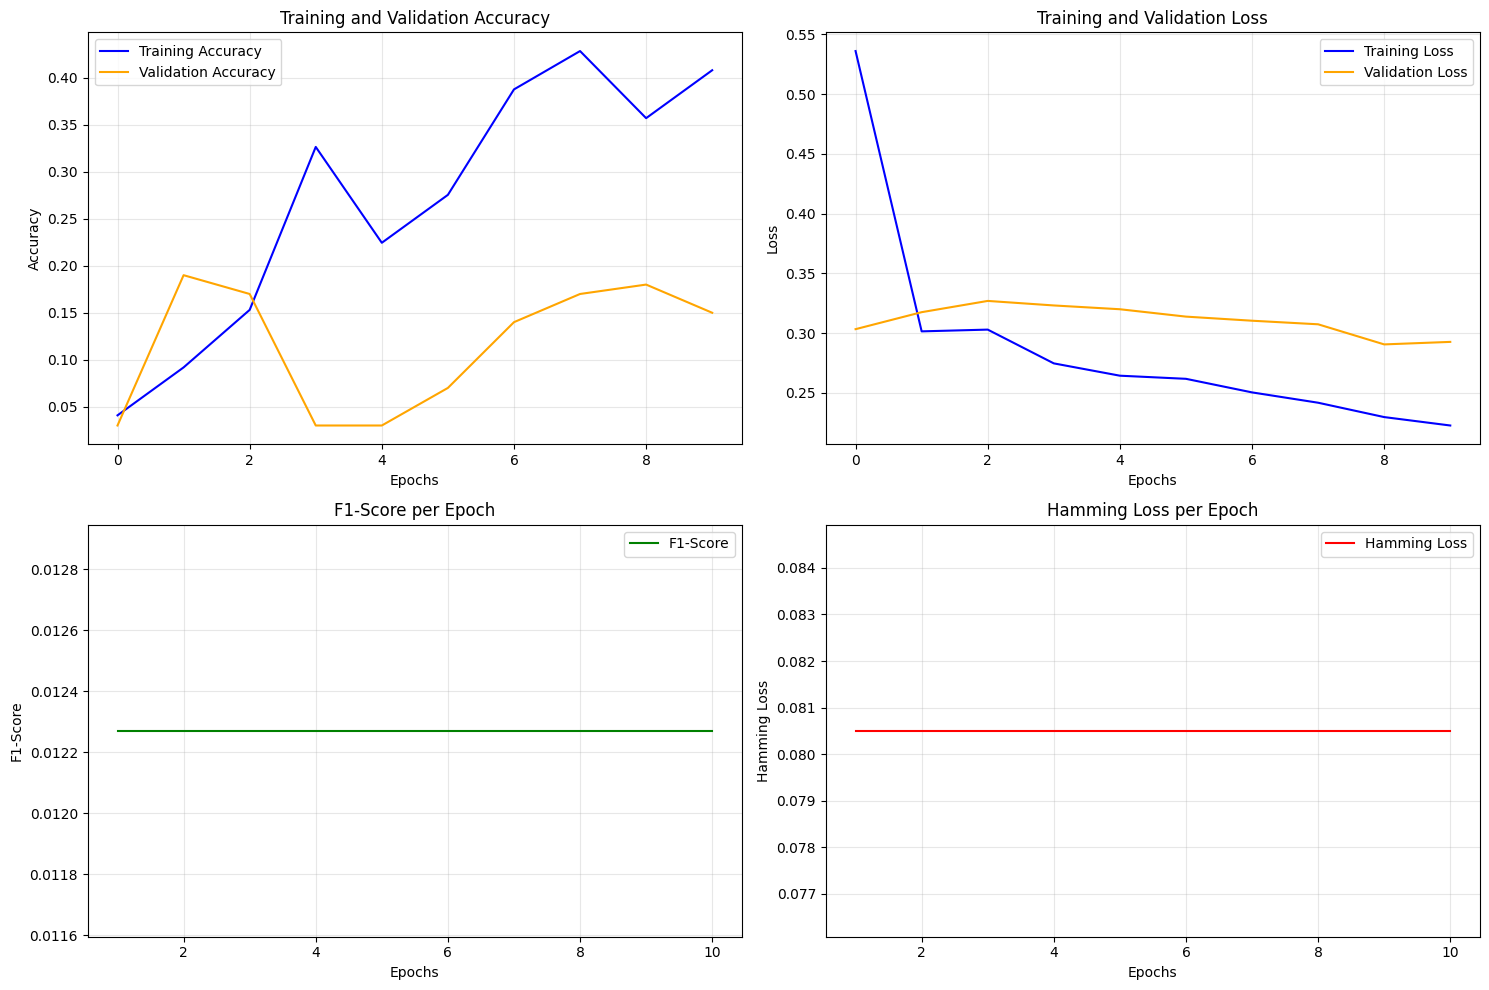

In [30]:
plot_metrics(history_corrected, f1_scores, hamming_losses)

# Holistic Label Correction (HLC) with GCN


In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

data, info = tfds.load("voc/2007", split="train[:20%]", with_info=True)

label_names = info.features["objects"]["label"].names
num_labels = len(label_names)

binary_labels = []
images = []

for sample in data:
    labels = np.zeros(num_labels, dtype=int)
    for label_id in sample["objects"]["label"].numpy():
        labels[label_id] = 1
    binary_labels.append(labels)
    image = Image.fromarray(sample["image"].numpy())
    image = image.resize((224, 224))
    images.append(np.array(image))

binary_labels = np.array(binary_labels)
images = np.array(images)
images = images.astype('float32')
images = images / 255.0

X_train, X_test, y_train, y_test = train_test_split(images, binary_labels, test_size=0.2, random_state=42)

noise_rate_samples = 0.2  # 20% of samples
noise_rate_columns = 0.2  # 20% of columns to contaminate

num_samples = len(y_train)
num_noisy_samples = int(num_samples * noise_rate_samples)
num_columns = y_train.shape[1]
num_noisy_columns = int(num_columns * noise_rate_columns)

np.random.seed(42)

noisy_sample_indices = np.random.choice(num_samples, num_noisy_samples, replace=False)
noisy_column_indices = np.random.choice(num_columns, num_noisy_columns, replace=False)

y_noisy = y_train.copy()

for idx in noisy_sample_indices:
    for col in noisy_column_indices:
        y_noisy[idx, col] = 1 - y_noisy[idx, col]

############################################################
# Define the Custom Dataset for PyTorch
############################################################

class CustomDatasetTorch(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        img_pil = Image.fromarray((image * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(img_pil)
        else:
            image = T.ToTensor()(img_pil)
        return image, label

############################################################
# Define the Dynamic Graph Convolution Layer
############################################################

class DynamicGraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, num_nodes):
        super(DynamicGraphConvolution, self).__init__()

        self.static_adj = nn.Sequential(
            nn.Conv1d(num_nodes, num_nodes, 1, bias=False),
            nn.LeakyReLU(0.2))
        self.static_weight = nn.Sequential(
            nn.Conv1d(in_features, out_features, 1),
            nn.LeakyReLU(0.2))

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.conv_global = nn.Conv1d(in_features, in_features, 1)
        self.bn_global = nn.BatchNorm1d(in_features)
        self.relu = nn.LeakyReLU(0.2)

        self.conv_create_co_mat = nn.Conv1d(in_features * 2, num_nodes, 1)
        self.dynamic_weight = nn.Conv1d(in_features, out_features, 1)

    def forward_static_gcn(self, x):
        x = self.static_adj(x.transpose(1, 2))
        x = self.static_weight(x.transpose(1, 2))
        return x

    def forward_construct_dynamic_graph(self, x):
        x_glb = self.gap(x)
        x_glb = self.conv_global(x_glb)
        x_glb = self.bn_global(x_glb)
        x_glb = self.relu(x_glb)
        x_glb = x_glb.expand(x_glb.size(0), x_glb.size(1), x.size(2))
        x = torch.cat((x_glb, x), dim=1)
        dynamic_adj = self.conv_create_co_mat(x)
        dynamic_adj = torch.sigmoid(dynamic_adj)
        return dynamic_adj

    def forward_dynamic_gcn(self, x, dynamic_adj):
        x = torch.matmul(x, dynamic_adj)
        x = self.relu(x)
        x = self.dynamic_weight(x)
        x = self.relu(x)
        return x

    def forward(self, x):
        out_static = self.forward_static_gcn(x)
        x = x + out_static
        dynamic_adj = self.forward_construct_dynamic_graph(x)
        x = self.forward_dynamic_gcn(x, dynamic_adj)
        return dynamic_adj, x

############################################################
# Define the ADD-GCN Model
############################################################

class ADD_GCN(nn.Module):
    def __init__(self, model, num_classes):
        super(ADD_GCN, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )
        self.num_classes = num_classes

        self.fc = nn.Conv2d(model.fc.in_features, num_classes, (1, 1), bias=False)

        self.conv_transform = nn.Conv2d(2048, 1024, (1, 1))
        self.relu = nn.LeakyReLU(0.2)

        self.gcn = DynamicGraphConvolution(1024, 1024, num_classes)

        self.mask_mat = nn.Parameter(torch.eye(self.num_classes).float())
        self.last_linear = nn.Conv1d(1024, self.num_classes, 1)

    def forward_feature(self, x):
        x = self.features(x)
        return x

    def forward_classification_sm(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), x.size(1), -1)
        x = x.topk(1, dim=-1)[0].mean(dim=-1)
        return x

    def forward_sam(self, x):
        mask = self.fc(x)
        mask = mask.view(mask.size(0), mask.size(1), -1)
        mask = torch.sigmoid(mask)
        mask = mask.transpose(1, 2)

        x = self.conv_transform(x)
        x = x.view(x.size(0), x.size(1), -1)
        x = torch.matmul(x, mask)
        return x

    def forward_dgcn(self, x):
        return self.gcn(x)

    def forward(self, x):
        x = self.forward_feature(x)
        out1 = self.forward_classification_sm(x)
        v = self.forward_sam(x)
        dag, dag_ = self.forward_dgcn(v)
        z = v + dag_
        out2 = self.last_linear(z)
        mask_mat = self.mask_mat.detach()
        out2 = (out2 * mask_mat).sum(-1)
        return torch.sigmoid((out1 + out2) / 2), dag

############################################################
# Train the HLC model
############################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hlc_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

hlc_train_dataset = CustomDatasetTorch(X_train, y_noisy, transform=hlc_transform)
hlc_test_dataset = CustomDatasetTorch(X_test, y_test, transform=hlc_transform)

hlc_train_loader = DataLoader(hlc_train_dataset, batch_size=32, shuffle=True)
hlc_test_loader = DataLoader(hlc_test_dataset, batch_size=32, shuffle=False)

hlc_model = ADD_GCN(torch_models.resnet50(pretrained=True), len(label_names))
hlc_model.to(device)

hlc_criterion = nn.BCELoss()
hlc_optimizer = torch.optim.Adam(hlc_model.parameters(), lr=1e-4)
hlc_num_epochs = 10

history_hlc = []

for epoch in range(hlc_num_epochs):
    hlc_model.train()
    for images_batch, labels_batch in hlc_train_loader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device).float()
        hlc_optimizer.zero_grad()
        outputs, _ = hlc_model(images_batch)
        loss = hlc_criterion(outputs, labels_batch)
        loss.backward()
        hlc_optimizer.step()

    hlc_model.eval()
    y_pred_list = []
    with torch.no_grad():
        for images_batch, _ in hlc_test_loader:
            images_batch = images_batch.to(device)
            outputs, _ = hlc_model(images_batch)
            y_pred_list.append(outputs.cpu().numpy())

    y_pred_hlc = (np.vstack(y_pred_list) > 0.5).astype(int)
    acc = accuracy_score(y_test.flatten(), y_pred_hlc.flatten())
    history_hlc.append(acc)

ap_scores = []
f1_scores = []
y_pred_binary = (y_pred_hlc > 0.5).astype(int)
for i in range(len(label_names)):
    ap = average_precision_score(y_test[:, i], y_pred_hlc[:, i])
    ap_scores.append(ap)
    f1_i = f1_score(y_test[:, i], y_pred_binary[:, i])
    f1_scores.append(f1_i)

hlc_map = np.mean(ap_scores)
hlc_f1 = np.mean(f1_scores)
hlc_accuracy = accuracy_score(y_test.flatten(), y_pred_binary.flatten())

def plot_metrics(f1_scores, hamming_losses):
    plt.figure(figsize=(15, 10))

    # F1 Score
    plt.subplot(2, 2, 1)
    plt.plot(range(1, 11), f1_scores, label='F1-Score', color='green')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Hamming Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, 11), hamming_losses, label='Hamming Loss', color='red')
    plt.title('Hamming Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Hamming Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_metrics(f1_scores, hamming_losses)


Selected noisy column indices: [10  0  9 13]
Introduced noise in 80 samples and 4 columns


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 95.5MB/s]


Epoch 1: HLC Balanced Accuracy = 0.9340
Epoch 2: HLC Balanced Accuracy = 0.9440
Epoch 3: HLC Balanced Accuracy = 0.9450
Epoch 4: HLC Balanced Accuracy = 0.9495
Epoch 5: HLC Balanced Accuracy = 0.9420
Epoch 6: HLC Balanced Accuracy = 0.9400
Epoch 7: HLC Balanced Accuracy = 0.9285
Epoch 8: HLC Balanced Accuracy = 0.9420
Epoch 9: HLC Balanced Accuracy = 0.9300
